### Imports and setup

In [73]:
import keras as ker
from keras.datasets import reuters
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n = 500 #10000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
num_words = n) 

train_data and test_data are made up of lists of intergers, where each integer corresponds to a word in a dictionary. n sets the number of most frequenctly used words to be included. 
train_labels and test_labels carry single integers, where each interger corresponds to one of 46 mutually exclusive topics. https://keras.io/api/datasets/reuters/. To find out what each of the topics are check out https://github.com/keras-team/keras/issues/12072.

In [49]:
# len(train_data)
# len(test_data)

### Decoding the newswires back to text

In [5]:
newswire_number = 1
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[newswire_number]])
print(decoded_newswire)

? ? ? ? ? lt ? ? and lt ? ? corp of ? have each ? 50 pct ? in ? company ? ? ? ? ? ? said in a statement it ? no financial ? of the ? ? ? ? ? in 1986 was 17 5 billion ? ? reuter 3


### Preparing the data

In [54]:
def vectorize_sequences(sequences, dimension=n):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # This discards the number of times that a most frequently use word was used.
    return results 
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


All input data is now of the same size. We also need to vectorize the label, which we will do using categorical encoding...

In [69]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note, there is a built-in way to do this on Keras. 

In [56]:
# from keras.utils.np_utils import to_categorical
# one_hot_train_labels = to_categorical(train_labels)
# one_hot_test_labels = to_categorical(test_labels)

### Building the network
For the binary classification problem, the dimensionality of our ouptut space was just 2. Now, the dimensionality is 46. For this reason, having intermediate layers with a dimensionality less than 46 could create an information bottleneck. We will thus choose to have two hidden layers of dimensionality 64.

In [63]:
 model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(n,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

The 46 dimensional softmax output layer ensures that output[i] is the propability that the given input belongs to class i. 

Compiling the model: the best loss function to use here is the categorical_crossentropy because it gives a measure of the distance between two probability distributions. 

In [64]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Validation

First, we set aside 1,000 samples in the training data to use as a validation set. To properly understand the distinction between a validation dataset and test dataset read this post https://machinelearningmastery.com/difference-test-validation-datasets/.

In [68]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [70]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 325us/step - loss: 2.8358 - accuracy: 0.4320 - val_loss: 2.0616 - val_accuracy: 0.5520
Epoch 2/20
7982/7982 [==============================] - 0s 28us/step - loss: 1.8143 - accuracy: 0.5957 - val_loss: 1.6234 - val_accuracy: 0.6270
Epoch 3/20
7982/7982 [==============================] - 0s 40us/step - loss: 1.5206 - accuracy: 0.6610 - val_loss: 1.4441 - val_accuracy: 0.6680
Epoch 4/20
7982/7982 [==============================] - 0s 33us/step - loss: 1.3599 - accuracy: 0.6984 - val_loss: 1.3209 - val_accuracy: 0.6980
Epoch 5/20
7982/7982 [==============================] - 0s 29us/step - loss: 1.2451 - accuracy: 0.7241 - val_loss: 1.2540 - val_accuracy: 0.7130
Epoch 6/20
7982/7982 [==============================] - 0s 26us/step - loss: 1.1563 - accuracy: 0.7434 - val_loss: 1.1884 - val_accuracy: 0.7340
Epoch 7/20
7982/7982 [==============================] - 0s 26us/step - loss: 1.08

###### Plotting the validation and training loss

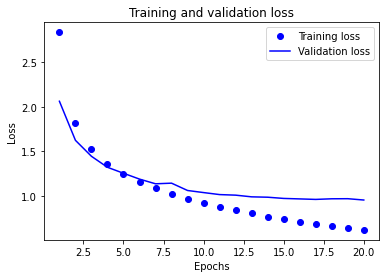

In [84]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###### Plotting the validation and training accuracy

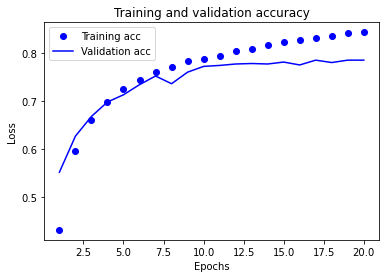

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Generating predictions on new data

In [86]:
predictions = model.predict(x_test)

Each entry in predictions is a vector of length 46. For example, 

In [92]:
i = 0
predictions[i].shape

(46,)

The elements of this vector sum one 1, which confirms that the softmax output generates a probability distribution over the 46 topics.

In [93]:
np.sum(predictions[i])

1.0000004

The largest entry corresponds to the class with the highest probability.

In [94]:
np.argmax(predictions[i])

3

In [96]:
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[i]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of ? co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said ? net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and ? ? ? to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash ? per share this year should be 2 50 to three dlrs reuter 3


### A different way to handle to labels and loss

In [1]:
# y_train = np.array(train_labels)
# y_test = np.array(test_labels)

If we take this appraoch, then we would need to alter the loss function to a sparse_categorical_crossentropy. 

In [2]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

NameError: name 'model' is not defined

### Experimenting with the dimension and number of the hidden layers

With a hidden-layer of dimension less than 46, we will create an information bottleneck:

In [3]:
# Architecture 
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(n,)))
model.add(layers.Dense(4, activation='relu')) #Here is the bottleneck! 
model.add(layers.Dense(46, activation='softmax'))
# Compiling 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# Fitting
model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

NameError: name 'models' is not defined

As expected, the accuracy drops drastically! 

### Wrapping up

The take home messages of this example are:
* When trying to classify data points into _N_ classes, the network should end with a _dense_ layer of size _N_.
* For single-label, multiclass classification problem the network should end with a softmax activation function to produce a probability distribution over the _N_ classes. 
* For these types of problems, the *categorical_crossentropy* is almost always the loss function of choice.
* There are two ways to handle labels in multiclass classification:
    * Encoding the labels via categorical encoding (also known as one-hot encoding) and using *categorical_crossentropy* as a loss function
    * Encoding the labels as integers and using the *sparse_categorical_crossentropy* loss function
* Avoid information bottlenecks!